In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [40]:
root = Path("C:/Users/Owner/Downloads/Udemy/Pytorch/Task02_Heart/Task02_Heart/imagesTr/")
label = Path("C:/Users/Owner/Downloads/Udemy/Pytorch/Task02_Heart/Task02_Heart/imagesTr/")

In [41]:
root

WindowsPath('C:/Users/Owner/Downloads/Udemy/Pytorch/Task02_Heart/Task02_Heart/imagesTr')

In [31]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [42]:
sample_path = list(root.glob("la*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [43]:
sample_path, sample_path_label

(WindowsPath('C:/Users/Owner/Downloads/Udemy/Pytorch/Task02_Heart/Task02_Heart/imagesTr/la_003.nii.gz'),
 WindowsPath('C:/Users/Owner/Downloads/Udemy/Pytorch/Task02_Heart/Task02_Heart/labelsTr/la_003.nii.gz'))

In [44]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)


In [45]:
data

In [46]:
label

In [47]:
mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [48]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [50]:
from celluloid import Camera
from IPython.display import HTML

In [51]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation

<IPython.core.display.Javascript object>

In [52]:
HTML(animation.to_html5_video())  # convert the animation to a video

In [53]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [54]:
all_files = list(root.glob("la*"))  # Get all subjects
len(all_files)

20

In [55]:
save_root = Path("C:/Users/Owner/Downloads/Udemy/Pytorch/06-Atrium-Segmentation/06-Atrium-SegmentationPreprocessed")

In [56]:
for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")    
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    # Check if train or val data and create corresponding path
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        

  0%|          | 0/20 [00:00<?, ?it/s]

In [57]:
path = Path(
    "C:/Users/Owner/Downloads/Udemy/Pytorch/06-Atrium-Segmentation/06-Atrium-SegmentationPreprocessed/train/1/")  # Select a subject


In [59]:
# Choose a file and load slice + mask
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


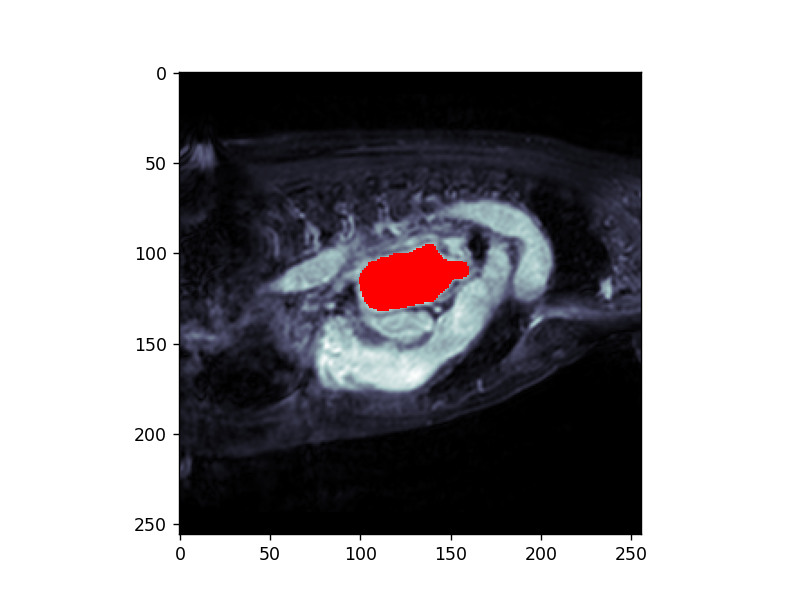

In [60]:
# Plot everything
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap="autumn")

In [61]:
print(slice.min(), slice.max())

0.0 0.8387631143014908
